In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,GlobalAveragePooling2D

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator as Imgen

from PIL import Image

In [2]:
pip install split-folders --quiet

Note: you may need to restart the kernel to use updated packages.


> Splitting into train test and val

In [3]:
import splitfolders
splitfolders.ratio("../input/vehicle-detection-image-set/data",output='splitted',ratio=(0.8,0.1,0.1))

Copying files: 17760 files [01:22, 215.80 files/s]


> Loading Dataset

In [4]:
train_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/train",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

val_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/val",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

test_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/test",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

Found 14207 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.
Found 1778 images belonging to 2 classes.


In [5]:
train_ds.class_indices

{'non-vehicles': 0, 'vehicles': 1}

In [6]:
x_train,y_train = next(train_ds)
print(x_train.shape,y_train.shape)

(32, 150, 150, 3) (32, 2)


> Seeing some images

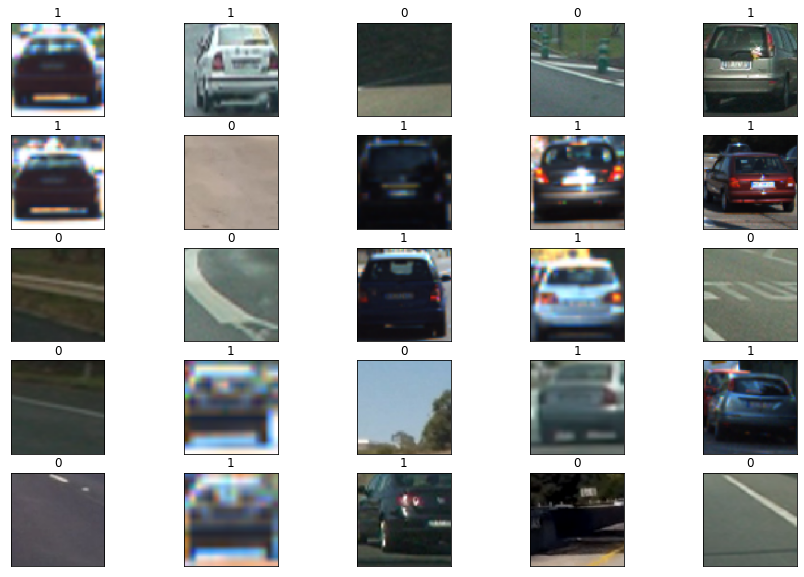

In [7]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.title(np.argmax(y_train[i]))

## Model

> importing pre-trained model

In [8]:
from keras.applications.xception import Xception

In [9]:
base_model = Xception(weights='imagenet',
                     input_shape=(150,150,3),
                      include_top=False
                     )
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [10]:
model = keras.models.Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(2,activation='relu'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
model.compile(optimizer='sgd',loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [14]:
#training the model
hist = model.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 callbacks=[callback]
                )

Epoch 1/10
444/444 [==============================] - 27s 47ms/step - loss: 0.5245 - accuracy: 0.9042 - val_loss: 0.4015 - val_accuracy: 0.9910
Epoch 2/10
444/444 [==============================] - 19s 43ms/step - loss: 0.3956 - accuracy: 0.9937 - val_loss: 0.3854 - val_accuracy: 0.9938
Epoch 3/10
444/444 [==============================] - 20s 44ms/step - loss: 0.3826 - accuracy: 0.9951 - val_loss: 0.3781 - val_accuracy: 0.9955
Epoch 4/10
444/444 [==============================] - 19s 44ms/step - loss: 0.3767 - accuracy: 0.9951 - val_loss: 0.3742 - val_accuracy: 0.9955
Epoch 5/10
444/444 [==============================] - 19s 43ms/step - loss: 0.3728 - accuracy: 0.9945 - val_loss: 0.3715 - val_accuracy: 0.9955
Epoch 6/10
444/444 [==============================] - 19s 43ms/step - loss: 0.3702 - accuracy: 0.9952 - val_loss: 0.3697 - val_accuracy: 0.9949


In [15]:
#test
model.evaluate(test_ds)

56/56 [==============================] - 2s 43ms/step - loss: 0.3679 - accuracy: 0.9961


[0.36791446805000305, 0.9960629940032959]

> Visualizing predictions

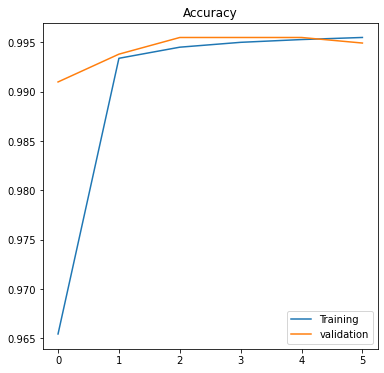

In [16]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()
plt.show()

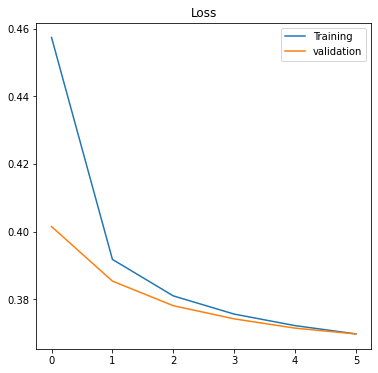

In [17]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [18]:
x_test,y_test = next(test_ds)

In [19]:
pred_test = model.predict(x_test)
pred_test = [np.argmax(i) for i in pred_test]

In [20]:
test_dict = test_ds.class_indices
li_pred = list(test_dict.keys())
li_pred

['non-vehicles', 'vehicles']

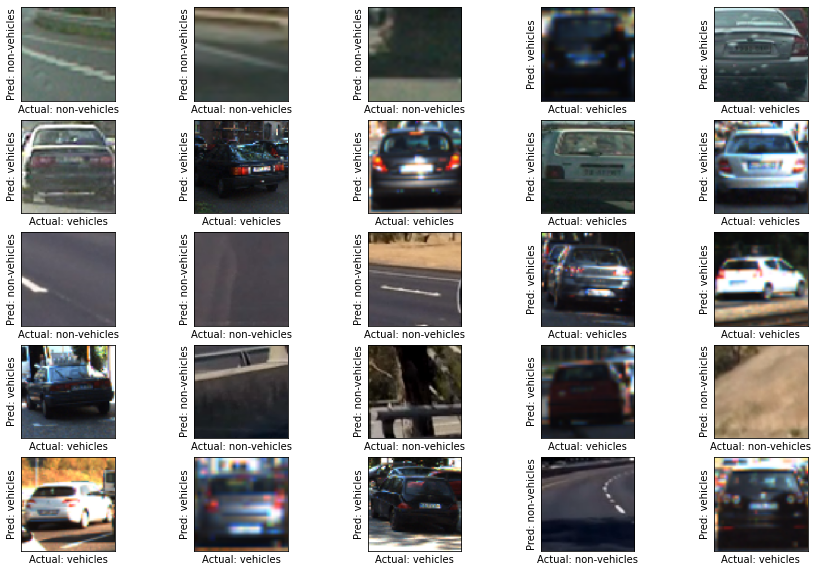

In [21]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i])
    plt.xlabel("Actual: {}".format(li_pred[np.argmax(y_test[i])]))
    plt.ylabel("Pred: {}".format(li_pred[pred_test[i]]))

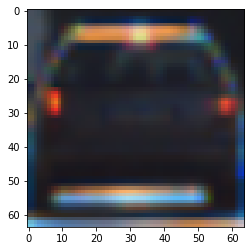

In [22]:
plt.imshow(Image.open("../input/vehicle-detection-image-set/data/vehicles/10.png"));

In [23]:
def predict_image(dir):
    img = image.load_img(dir,target_size=(150,150))
    img  = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    pred_img = model.predict(img)
    
    return li_pred[np.argmax(pred_img)]

In [24]:
print(predict_image('../input/vehicle-detection-image-set/data/vehicles/10.png'))

vehicles
